# Analysis Notebook

#### Initialisation Cells

In [1]:
import os
import sys
import re
import ast
import json
import matplotlib.pyplot as plt

sys.path.append("../src")

from config import Parser
from data import DatasetManager
from models import LogisticRegressionClf, RandomForestClf, XGBoostClf, MetaPath2VecClf, GNNClf

LEARNERS = {
    "logistic-regression": LogisticRegressionClf,
    "random-forest": RandomForestClf,
    "xgboost": XGBoostClf,
    "metapath2vec": MetaPath2VecClf,
    "gnn": GNNClf
}


def load_experiment(path):
    with open(os.path.join(path, "report.md"), "r") as report_file:
        reading = True
        while reading:
            line = report_file.readline()
            reading = False if re.compile(r"--END--").search(line) else True
            
            match = re.compile(r"## Config").search(line)
            if match:
                config = ""
                line = report_file.readline()
                end = False
                while not end:
                    config += line
                    line = report_file.readline()
                    end = True if re.compile(r"## Data").search(line) else False
                
    config = json.loads(config)
    
    parser = Parser(config)
    exp_args, data_args, model_args, train_args = parser.parse()
    
    data = DatasetManager(data_args["type"], data_args["args"])
    data.data.remove_data()

    data_args["args"]["customer_transforms"] = data.data.customer_transforms
    data_args["args"]["product_transforms"] = data.data.product_transforms

    test_data = DatasetManager(data_args["type"], data_args["args"], test=True)
    test_data.data.remove_data()
    
    model = LEARNERS[model_args["type"]](data, test_data, val_dataset=False, loss=model_args["loss"], model_args=model_args["args"])
    
    model.load(path)

    return test_data, model

def get_GNN_and_testdata(path):
    test_data_gnn, model_gnn = load_experiment(path)
    return model_gnn, test_data_gnn

def get_edge_results(data, preds, targets):
    import torch
    import pandas as pd
    import numpy as np

    customer_node_lookup = pd.DataFrame(torch.stack([data.data[0]["customer"].node_index, data.data[0]["customer"].originalID], 
                    axis=1).numpy(), columns=["customer_id", "hash(customerId)"])

    variant_node_lookup = pd.DataFrame(torch.stack([data.data[0]["variant"].node_index, data.data[0]["variant"].originalID], 
                    axis=1).numpy(), columns=["variant_id", "variantID"])

    edge_results = pd.DataFrame(data.data[0]["customer", "purchases", "variant"].edge_index.T.numpy(), 
                                columns=["customer_id", "variant_id"])
    edge_results["prediction"] = np.round(preds.detach().numpy()[:,1]).astype(np.int32)
    edge_results["target"] = targets
    edge_results = pd.merge(edge_results, customer_node_lookup, on="customer_id", how="inner")
    edge_results = pd.merge(edge_results, variant_node_lookup, on="variant_id", how="inner")
    return edge_results

/opt/anaconda3/envs/asos-gnn-returns-pygnightly/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setting up the analysis

Here we load in a particular experiment for error analysis.

In [61]:
data, model = load_experiment("../results/test/gnn_modelC_full_minibatching_128")
preds = model.model.forward(data.data[0].x_dict, data.data[0].edge_index_dict,
                            data.data[0]["customer", "purchases", "variant"].edge_index)
targets = data.data[0]["customer", "purchases", "variant"].edge_label

edge_results = get_edge_results(data, preds, targets)

Processing...
Done!
Processing...
Done!


In [66]:
print(data.data[0]["customer", "purchases", "variant"].edge_index)

tensor([[161851, 161851, 161852,  ..., 202058, 202062, 202063],
        [ 54567,  48165,  77074,  ..., 151299,  65330, 141926]])


### Confusion Matrix Analysis

Using the models predictions we can reconstruct the elements of the confusion matrix.

In [24]:
tp = edge_results[(edge_results.prediction == 1) & (edge_results.target == 1)]
fp = edge_results[(edge_results.prediction == 1) & (edge_results.target == 0)]
tn = edge_results[(edge_results.prediction == 0) & (edge_results.target == 0)]
fn = edge_results[(edge_results.prediction == 0) & (edge_results.target == 1)]

print(f"""TP: {100*len(tp)/len(edge_results):.2f}%, \
        \nFP: {100*len(fp)/len(edge_results):.2f}%, \
        \nTN: {100*len(tn)/len(edge_results):.2f}%, \
        \nFN: {100*len(fn)/len(edge_results):.2f}%""")

TP: 28.08%,         
FP: 8.18%,         
TN: 55.89%,         
FN: 7.85%


#### Single Market Confusion Matrices

First we need to find all the raw features for the predictions by merging some datasets.

In [25]:
import pandas as pd

cust_idx = pd.Series(data.data[0]["customer"].originalID.numpy(), name="hash(customerId)")
cust_x = pd.read_csv("../raw/gnn_data/customer_nodes_testing.csv")
customers = pd.merge(cust_x, cust_idx, on="hash(customerId)", how="inner")

var_idx = pd.Series(data.data[0]["variant"].originalID.numpy(), name="variantID")
var_x = pd.read_csv("../raw/gnn_data/product_nodes_testing.csv")
variants = pd.merge(var_x, var_idx, on="variantID", how="inner")

In [26]:
tp_cust = pd.merge(tp["hash(customerId)"], customers, on="hash(customerId)", how="inner").drop_duplicates().reset_index(drop=True)
tp_var = pd.merge(tp["variantID"], variants, on="variantID", how="inner").drop_duplicates().reset_index(drop=True)

fn_cust = pd.merge(fn["hash(customerId)"], customers, on="hash(customerId)", how="inner").drop_duplicates().reset_index(drop=True)
fn_var = pd.merge(fn["variantID"], variants, on="variantID", how="inner").drop_duplicates().reset_index(drop=True)

tn_cust = pd.merge(tn["hash(customerId)"], customers, on="hash(customerId)", how="inner").drop_duplicates().reset_index(drop=True)
tn_var = pd.merge(tn["variantID"], variants, on="variantID", how="inner").drop_duplicates().reset_index(drop=True)

fp_cust = pd.merge(fp["hash(customerId)"], customers, on="hash(customerId)", how="inner").drop_duplicates().reset_index(drop=True)
fp_var = pd.merge(fp["variantID"], variants, on="variantID", how="inner").drop_duplicates().reset_index(drop=True)


##### Country Markets

Now we have the customer and product information which was involved in a TP, TN, FP and FN prediction.

In [ ]:
for country in customers.shippingCountry.unique():
    tp_temp = tp_cust[tp_cust["shippingCountry"] == country]
    fn_temp = fn_cust[fn_cust["shippingCountry"] == country]
    tn_temp = tn_cust[tp_cust["shippingCountry"] == country]
    fp_temp = fp_cust[tp_cust["shippingCountry"] == country]

    country_total = len(tp_temp) + len(fn_temp) + len(tn_temp) + len(fp_temp)
    
    print(f"""\nCountry: {country}
        \nTP: {100*len(tp_temp)/country_total:.2f}%, \
        \nFP: {100*len(fn_temp)/country_total:.2f}%, \
        \nTN: {100*len(tn_temp)/country_total:.2f}%, \
        \nFN: {100*len(fp_temp)/country_total:.2f}%\n""")

##### Brand Markets

In [ ]:
for brand in variants.brandDesc.unique():
    tp_temp = tp_var[tp_var["brandDesc"] == brand]
    fn_temp = fn_var[fn_var["brandDesc"] == brand]
    tn_temp = tn_var[tp_var["brandDesc"] == brand]
    fp_temp = fp_var[tp_var["brandDesc"] == brand]

    brand_total = len(tp_temp) + len(fn_temp) + len(tn_temp) + len(fp_temp)
    
    print(f"""\nBrand: {brand}
        \nTP: {100*len(tp_temp)/brand_total:.2f}%, \
        \nFP: {100*len(fn_temp)/brand_total:.2f}%, \
        \nTN: {100*len(tn_temp)/brand_total:.2f}%, \
        \nFN: {100*len(fp_temp)/brand_total:.2f}%\n""")

##### Product Type Markets

In [ ]:
for prodType in variants.productType.unique():
    tp_temp = tp_var[tp_var["productType"] == prodType]
    fn_temp = fn_var[fn_var["productType"] == prodType]
    tn_temp = tn_var[tp_var["productType"] == prodType]
    fp_temp = fp_var[tp_var["productType"] == prodType]

    type_total = len(tp_temp) + len(fn_temp) + len(tn_temp) + len(fp_temp)
    
    print(f"""\nProductType: {prodType}
        \nTP: {100*len(tp_temp)/type_total:.2f}%, \
        \nFP: {100*len(fn_temp)/type_total:.2f}%, \
        \nTN: {100*len(tn_temp)/type_total:.2f}%, \
        \nFN: {100*len(fp_temp)/type_total:.2f}%\n""")

##### Specific Feature Analysis

From here we can investigate a more in depth analysis of the individual features.

In [ ]:
tp_cust["pred_type"] = "TP"
tp_var["pred_type"] = "TP"
fn_cust["pred_type"] = "FN"
fn_var["pred_type"] = "FN"
tn_cust["pred_type"] = "TN"
tn_var["pred_type"] = "TN"
fp_cust["pred_type"] = "FP"
fp_var["pred_type"] = "FP"

# Get all the positive return examples
tpfn_cust = pd.concat([tp_cust.sample(n=1000), fn_cust.sample(n=1000)]).reset_index(drop=True)
tpfn_var = pd.concat([tp_var.sample(n=1000), fn_var.sample(n=1000)]).reset_index(drop=True)

# Get all the negative return examples
tnfp_cust = pd.concat([tn_cust.sample(n=1000), fp_cust.sample(n=1000)]).reset_index(drop=True)
tnfp_var = pd.concat([tn_var.sample(n=1000), fp_var.sample(n=1000)]).reset_index(drop=True)


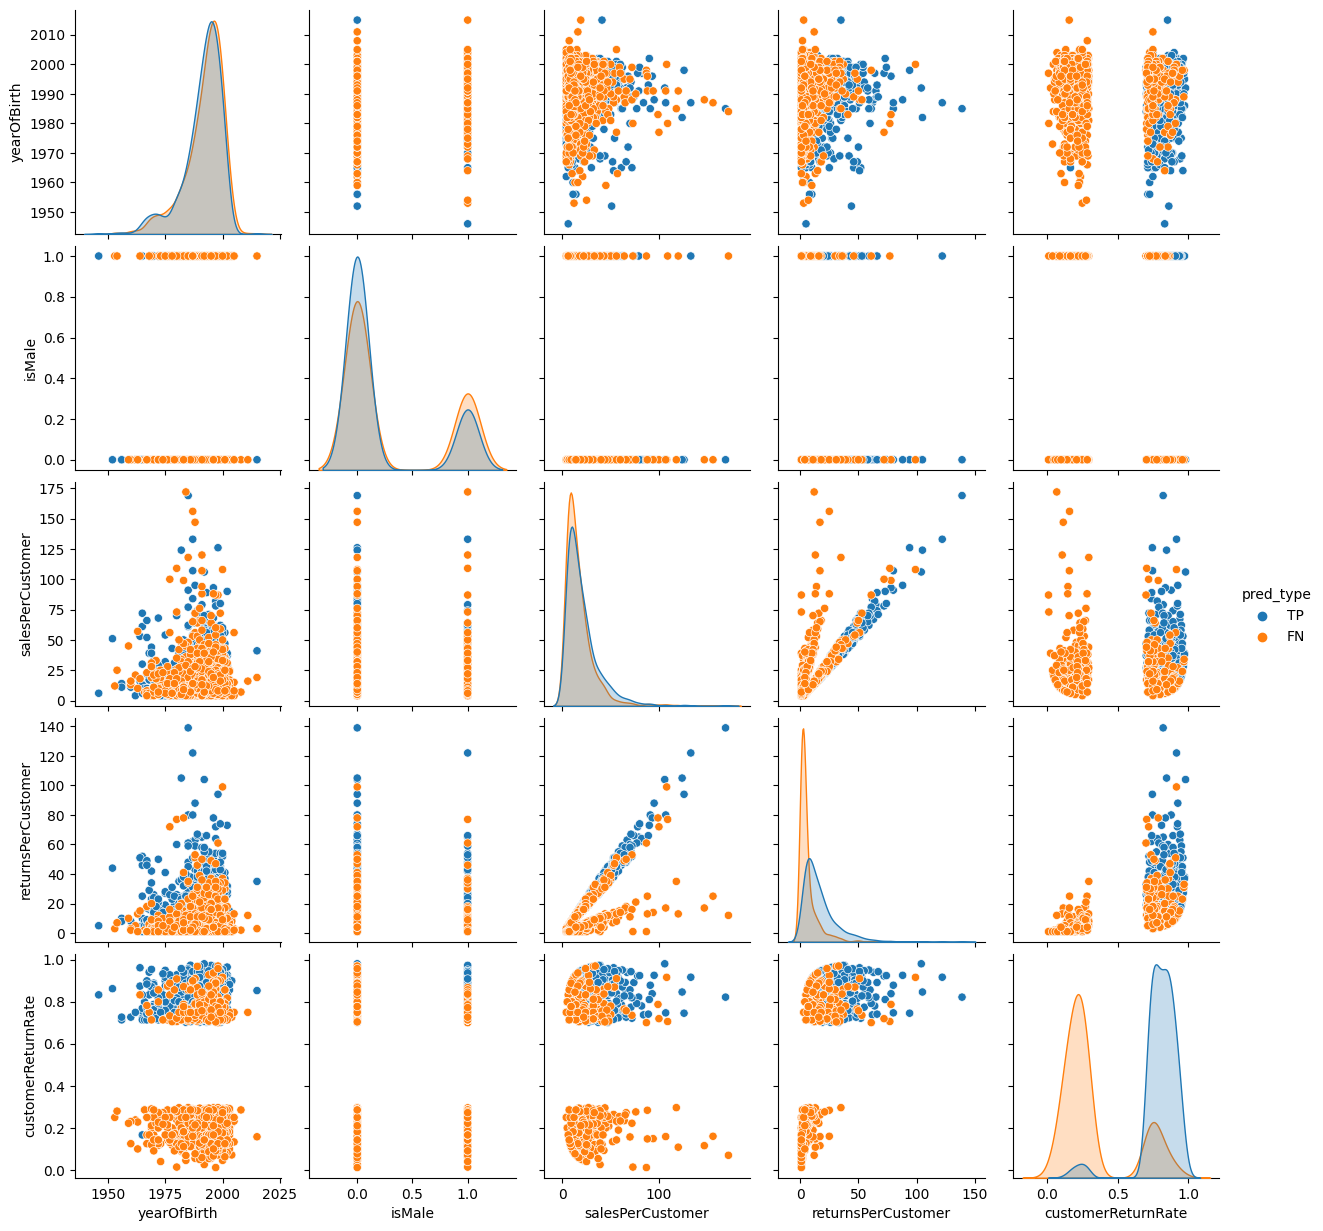

In [ ]:
import seaborn as sns

sns.pairplot(data=tpfn_cust[["yearOfBirth", 
                               "isMale", 
                               "salesPerCustomer", 
                               "returnsPerCustomer", 
                               "customerReturnRate", 
                               "pred_type"]], hue="pred_type")

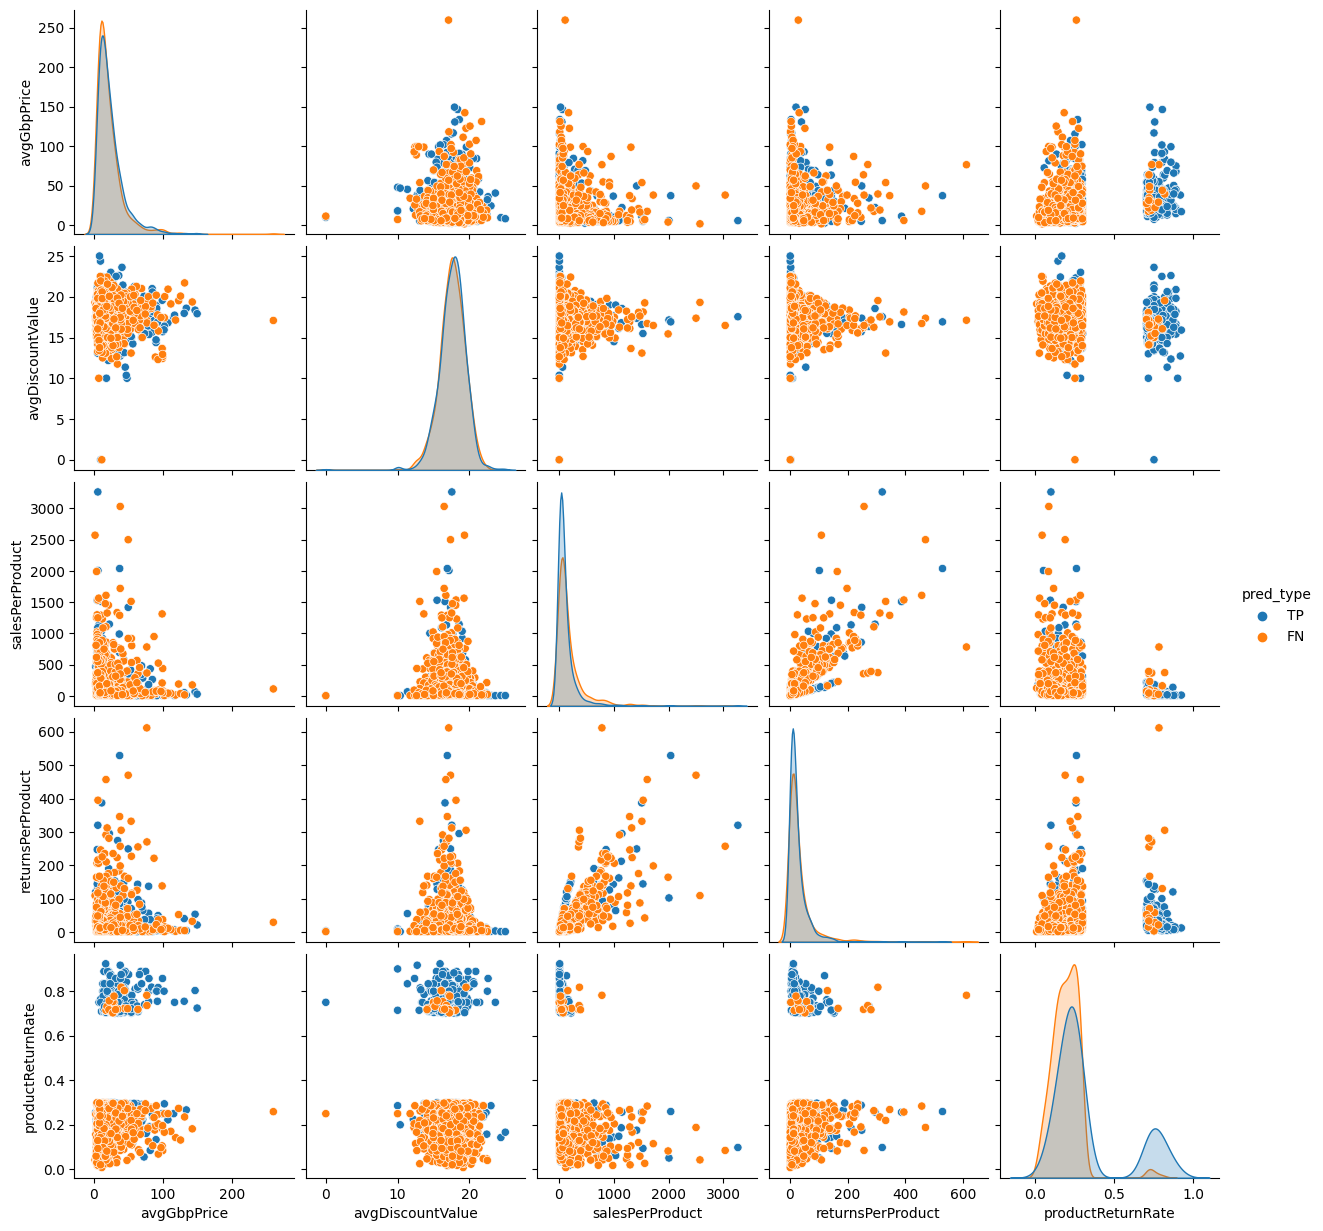

In [ ]:
sns.pairplot(data=tpfn_var[["avgGbpPrice",
                        "avgDiscountValue", 
                        "salesPerProduct", 
                        "returnsPerProduct", 
                        "productReturnRate", 
                               "pred_type"]], hue="pred_type")

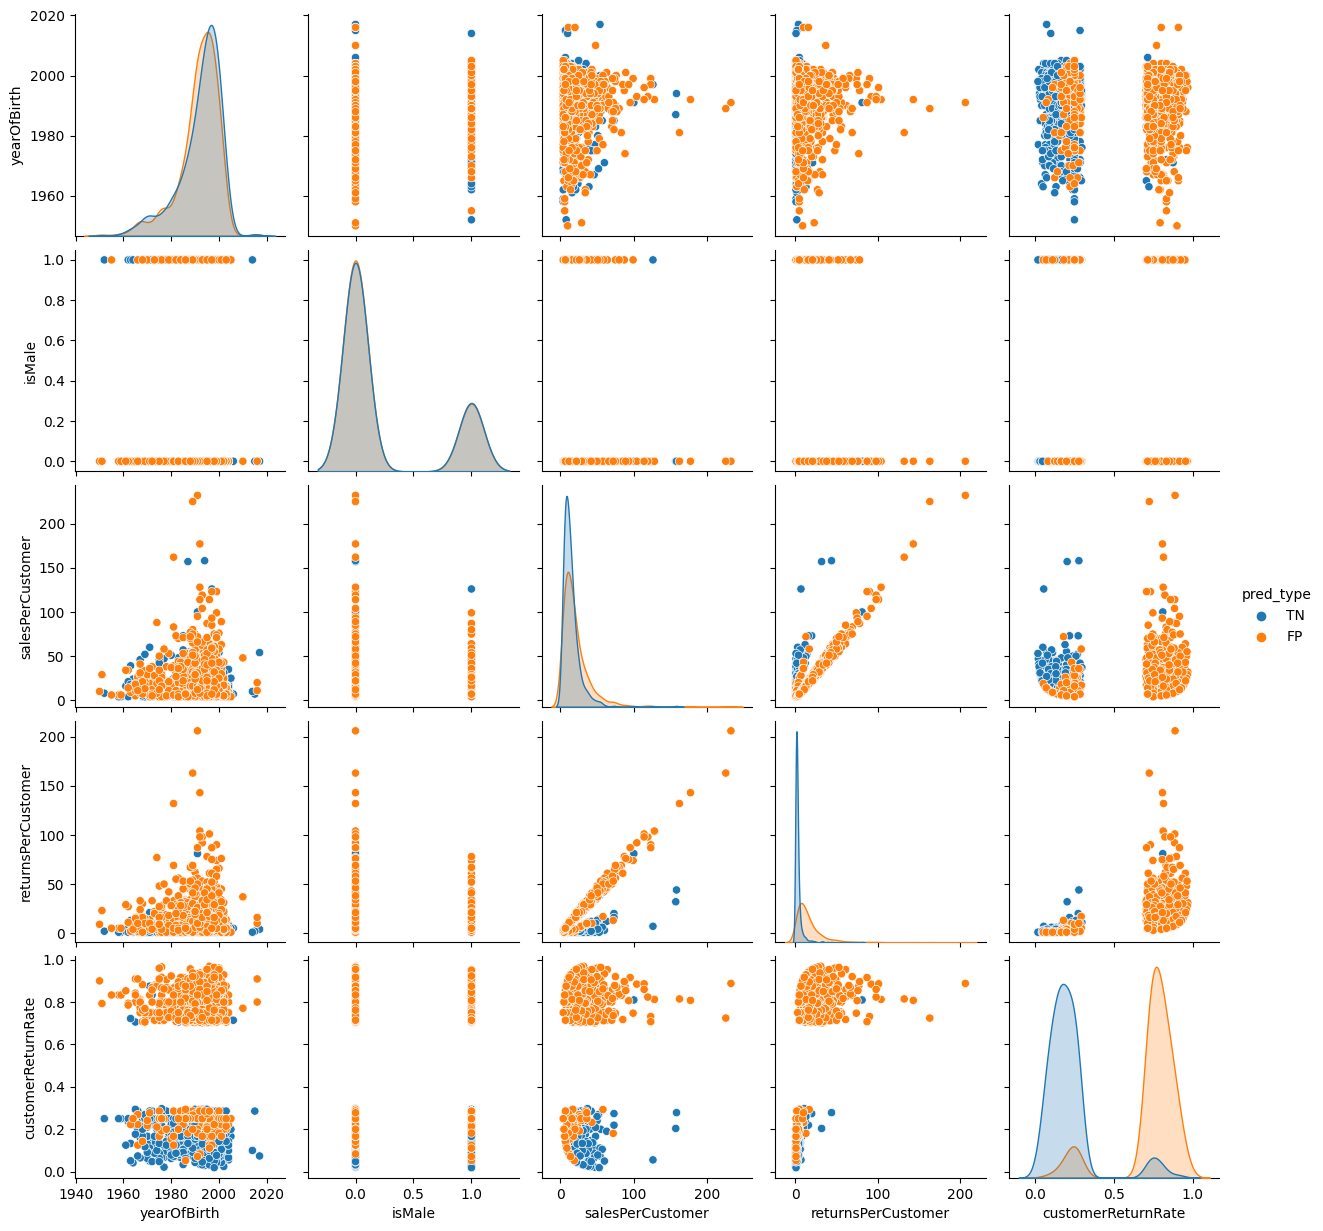

In [ ]:
sns.pairplot(data=tnfp_cust[["yearOfBirth", 
                               "isMale", 
                               "salesPerCustomer", 
                               "returnsPerCustomer", 
                               "customerReturnRate", 
                               "pred_type"]], hue="pred_type")

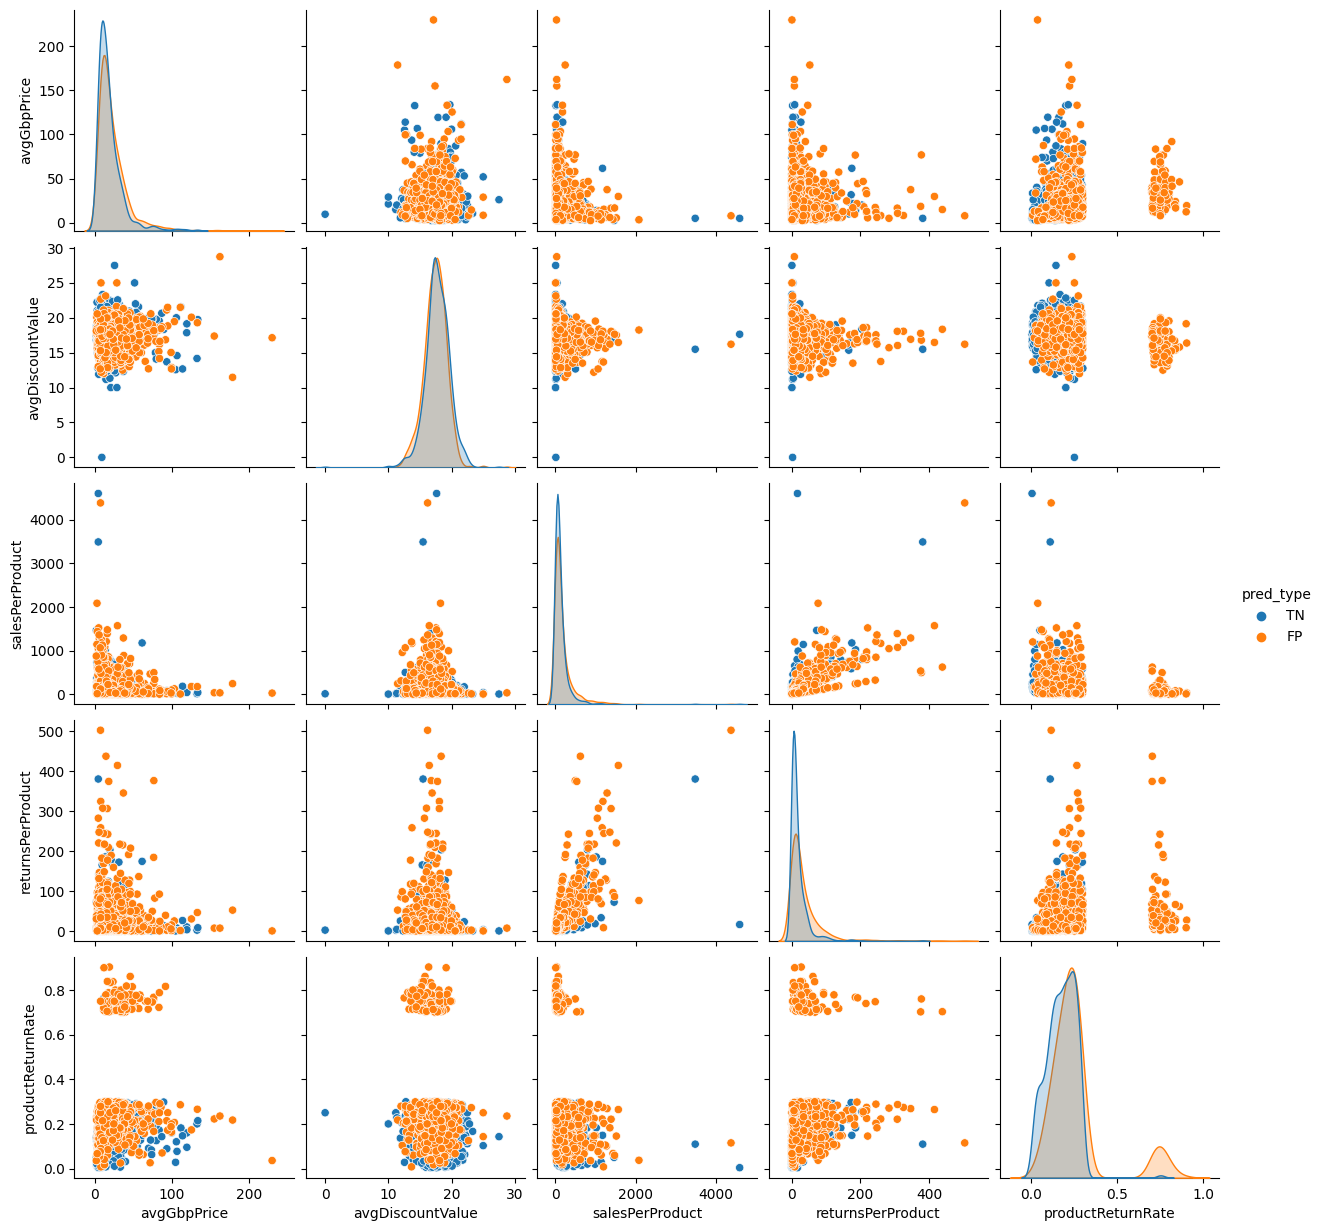

In [ ]:
sns.pairplot(data=tnfp_var[["avgGbpPrice",
                        "avgDiscountValue", 
                        "salesPerProduct", 
                        "returnsPerProduct", 
                        "productReturnRate", 
                               "pred_type"]], hue="pred_type")

### Average example of TP, FP, TN and FN

Now we have this inforamtion we should try and calculate an average example of a product and customer which falls into the category of TP, FP, TN and FN.

##### Average Customer Item return interaction that is predicted as a return (TP)

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

In [ ]:
tp_avg_features = pd.merge(pd.merge(tp[["hash(customerId)", "variantID"]], customers, 
                    on="hash(customerId)", how="inner"), variants, 
                    on="variantID", how="inner").drop(["hash(customerId)", "variantID"], axis=1).mean()
print(tp_avg_features)

yearOfBirth                                                  1.991309e+03
isMale                                                       2.259032e-01
premier                                                      2.870577e-01
salesPerCustomer                                             2.363499e+01
returnsPerCustomer                                           1.938102e+01
customerReturnRate                                           8.008625e-01
customerId_level_(Looks different to image on site)_ratio    3.074894e-02
customerId_level_(More_than_one_size_ordered)_ratio          6.607208e-02
customerId_level_(Late_Delivery)_ratio                       7.116726e-03
customerId_level_(Poor Quality)_ratio                        4.390602e-02
customerId_level_(Doesn't fit)_ratio                         3.970689e-05
customerId_level_(Doesn't suit)_ratio                        3.632407e-01
customerId_level_(Incorrect item)_ratio                      6.301687e-03
customerId_level_(Parcel Damaged)_rati

/opt/anaconda3/envs/asos-gnn-returns-pygnightly/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


##### Average Customer Item no return interaction that is predicted as a return (FP)

In [ ]:
fp_avg_features = pd.merge(pd.merge(fp[["hash(customerId)", "variantID"]], customers, 
                    on="hash(customerId)", how="inner"), variants, 
                    on="variantID", how="inner").drop(["hash(customerId)", "variantID"], axis=1).mean()
fp_avg_features

/opt/anaconda3/envs/asos-gnn-returns-pygnightly/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


yearOfBirth                                                  1.991363e+03
isMale                                                       2.334204e-01
premier                                                      2.927546e-01
salesPerCustomer                                             2.233081e+01
returnsPerCustomer                                           1.699928e+01
customerReturnRate                                           7.337725e-01
customerId_level_(Looks different to image on site)_ratio    2.899550e-02
customerId_level_(More_than_one_size_ordered)_ratio          6.351251e-02
customerId_level_(Late_Delivery)_ratio                       6.835244e-03
customerId_level_(Poor Quality)_ratio                        4.382375e-02
customerId_level_(Doesn't fit)_ratio                         1.365665e-05
customerId_level_(Doesn't suit)_ratio                        3.441946e-01
customerId_level_(Incorrect item)_ratio                      7.561783e-03
customerId_level_(Parcel Damaged)_rati

##### Average Customer Item no return interaction that is predicted as not a return (TN)

In [ ]:
tn_avg_features = pd.merge(pd.merge(tn[["hash(customerId)", "variantID"]], customers, 
                    on="hash(customerId)", how="inner"), variants, 
                    on="variantID", how="inner").drop(["hash(customerId)", "variantID"], axis=1).mean()
tn_avg_features

/opt/anaconda3/envs/asos-gnn-returns-pygnightly/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


yearOfBirth                                                  1.991611e+03
isMale                                                       2.605721e-01
premier                                                      2.870580e-01
salesPerCustomer                                             1.784878e+01
returnsPerCustomer                                           3.351944e+00
customerReturnRate                                           1.992398e-01
customerId_level_(Looks different to image on site)_ratio    4.141355e-02
customerId_level_(More_than_one_size_ordered)_ratio          3.654743e-02
customerId_level_(Late_Delivery)_ratio                       5.087560e-03
customerId_level_(Poor Quality)_ratio                        3.867931e-02
customerId_level_(Doesn't fit)_ratio                         5.543938e-05
customerId_level_(Doesn't suit)_ratio                        2.561424e-01
customerId_level_(Incorrect item)_ratio                      1.940747e-02
customerId_level_(Parcel Damaged)_rati

##### Average Customer Item return interaction that is predicted as not a return (FN)

In [ ]:
fn_avg_features = pd.merge(pd.merge(fn[["hash(customerId)", "variantID"]], customers, 
                    on="hash(customerId)", how="inner"), variants, 
                    on="variantID", how="inner").drop(["hash(customerId)", "variantID"], axis=1).mean()
fn_avg_features

/opt/anaconda3/envs/asos-gnn-returns-pygnightly/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


yearOfBirth                                                  1.991675e+03
isMale                                                       2.953237e-01
premier                                                      2.953884e-01
salesPerCustomer                                             1.824837e+01
returnsPerCustomer                                           6.514650e+00
customerReturnRate                                           3.331113e-01
customerId_level_(Looks different to image on site)_ratio    4.043270e-02
customerId_level_(More_than_one_size_ordered)_ratio          3.766658e-02
customerId_level_(Late_Delivery)_ratio                       6.650490e-03
customerId_level_(Poor Quality)_ratio                        3.866415e-02
customerId_level_(Doesn't fit)_ratio                         1.770452e-04
customerId_level_(Doesn't suit)_ratio                        2.937607e-01
customerId_level_(Incorrect item)_ratio                      1.376180e-02
customerId_level_(Parcel Damaged)_rati

## Oversmoothing Analysis

There doesn't seem to be too much separation between the features which makes sense because it is definitely not a linear problem. So now we should check for a measure of oversmoothing by looking at the mean average distance between class predictions in the embedding space.

In [29]:
from torch_geometric.loader import NeighborLoader

dataloader = NeighborLoader(
            data.data[0],
            directed=False,
            # Sample 30 neighbors for each node for 2 iterations
            num_neighbors={key: [10] * 2 for key in data.data[0].edge_types},
            # Use a batch size of 128 for sampling training nodes
            batch_size=128,
            input_nodes=("customer", data.data[0]["customer"].node_index)
        )

batch = next(iter(dataloader))

In [ ]:
print(batch)

In [30]:
preds = model.model.forward(batch.x_dict, batch.edge_index_dict,
                            batch["customer", "purchases", "variant"].edge_index)
targets = batch["customer", "purchases", "variant"].edge_label

emb_dict = model.model.encoder(batch.x_dict, batch.edge_index_dict)

In [31]:
import numpy as np

preds_rounded = np.round(preds[:,1].detach().numpy())
targets_rounded= np.round(targets.detach().numpy())

In [50]:
import torch

edge_embs = [torch.concat([emb_dict["customer"][src], emb_dict["variant"][dst]]) for src, dst in batch.edge_index_dict["customer", "purchases", "variant"].T]

pred_pos_edge_embs = np.array([edge_embs[ind].detach().numpy() for ind in np.where(preds_rounded == 1)[0]])
pred_neg_edge_embs = np.array([edge_embs[ind].detach().numpy() for ind in np.where(preds_rounded == 0)[0]])


targets_pos_edge_embs = np.array([edge_embs[ind].detach().numpy() for ind in np.where(targets_rounded == 1)[0]])
targets_neg_edge_embs = np.array([edge_embs[ind].detach().numpy() for ind in np.where(targets_rounded == 0)[0]])

In [59]:
print(targets_pos_edge_embs)

[[ 3.5927985e-02 -2.0375576e-04  5.2670643e-02 ... -3.5574730e-04
   8.4355392e-02  1.3850394e-01]
 [ 3.9982438e-02 -2.2206210e-04  7.7727959e-02 ... -3.5574730e-04
   8.4355392e-02  1.3850394e-01]
 [ 5.9690285e-03 -6.1730243e-04  3.0518146e-02 ...  1.7308715e-01
  -9.1774424e-04 -9.4516843e-04]
 ...
 [ 8.2237124e-02  3.5477780e-02  2.2671595e-01 ... -2.9707779e-04
   1.3550985e-01  1.6483057e-01]
 [ 2.2189187e-02 -0.0000000e+00  6.0424298e-02 ... -2.9707779e-04
   1.3550985e-01  1.6483057e-01]
 [ 1.2732732e-01  1.0050884e-01  2.5419211e-01 ...  9.6745431e-02
  -6.0311181e-04 -5.5461336e-04]]


In [51]:
from scipy.spatial import distance

pos_dist = distance.pdist(pred_pos_edge_embs, metric="cosine")
neg_dist = distance.pdist(pred_neg_edge_embs, metric="cosine")

targets_pos_dist = distance.pdist(targets_pos_edge_embs, metric="cosine")
targets_neg_dist = distance.pdist(targets_neg_edge_embs, metric="cosine")

pos_neg_dist = distance.cdist(pred_pos_edge_embs, pred_neg_edge_embs, metric="cosine")
targets_pos_neg_dist = distance.cdist(targets_pos_edge_embs, targets_neg_edge_embs, metric="cosine")


In [52]:
print("Positive Return Example Class")
print(f"Mean average distance (+/- 1 std. dev.): {np.mean(pos_dist):.2f} +/- {np.std(pos_dist):.2f}")
print("")
print("Negative Return Example Class")
print(f"Mean average distance (+/- 1 std. dev.): {np.mean(neg_dist):.2f} +/- {np.std(neg_dist):.2f}")
print("")

print("Distance between classes")
print(f"Mean average distance (+/- 1 std. dev.): {np.mean(pos_neg_dist):.2f} +/- {np.std(pos_neg_dist):.2f}")
print("")

Positive Return Example Class
Mean average distance (+/- 1 std. dev.): 0.32 +/- 0.13

Negative Return Example Class
Mean average distance (+/- 1 std. dev.): 0.38 +/- 0.13

Distance between classes
Mean average distance (+/- 1 std. dev.): 0.63 +/- 0.16



In [53]:
print("Positive Target Return Example Class")
print(f"Mean average distance (+/- 1 std. dev.): {np.mean(targets_pos_dist):.2f} +/- {np.std(targets_pos_dist):.2f}")
print("")
print("Negative Target Return Example Class")
print(f"Mean average distance (+/- 1 std. dev.): {np.mean(targets_neg_dist):.2f} +/- {np.std(targets_neg_dist):.2f}")
print("")

print("Distance Target between classes")
print(f"Mean average distance (+/- 1 std. dev.): {np.mean(targets_pos_neg_dist):.2f} +/- {np.std(targets_pos_neg_dist):.2f}")
print("")

Positive Target Return Example Class
Mean average distance (+/- 1 std. dev.): 0.39 +/- 0.16

Negative Target Return Example Class
Mean average distance (+/- 1 std. dev.): 0.43 +/- 0.16

Distance Target between classes
Mean average distance (+/- 1 std. dev.): 0.58 +/- 0.19



## Phase 1 Results code

In [54]:
full_test_args = {
                    "args": {
                        "load_path": "../",
                        "reduced": False,
                        "include_product_nodes": True,
                        "customer_transforms": {
                            "dropcol": {
                                "cols": ["shippingCountry"]
                            },
                            "removeoutliers": True,
                            "dropyob": True
                        },
                        "product_transforms": {
                            "dropcol": {
                                "cols": ["brandDesc", "productType"]
                            },
                            "removeoutliers": True
                        }
                    }
                }

full_test_data_pyg = DatasetManager("gnn-pyg", full_test_args["args"], test=True)
full_test_dataset_pyg = full_test_data_pyg.data
full_test_dataset_pyg.remove_data()


full_test_data_sk = DatasetManager("baseline-sklearn", full_test_args["args"], test=True)
full_test_dataset_sk = full_test_data_sk.data

TypeError: __init__() got an unexpected keyword argument 'include_product_nodes'

In [ ]:
full_test_dataset_pyg[0]

NameError: name 'full_test_dataset_pyg' is not defined

In [ ]:
full_test_args_no_productType = {
                    "args": {
                        "load_path": "../",
                        "reduced": False,
                        #"include_product_nodes": False,
                        "customer_transforms": {
                            "dropcol": {
                                "cols": ["shippingCountry"]
                            },
                            "removeoutliers": True,
                            "dropyob": True
                        },
                        "product_transforms": {
                            "dropcol": {
                                "cols": ["brandDesc", "productType"]
                            },
                            "removeoutliers": True
                        }
                    }
                }

full_test_data_pyg_noType = DatasetManager("gnn-pyg", full_test_args_no_productType["args"], test=True)
full_test_dataset_pyg_noType = full_test_data_pyg_noType.data
full_test_dataset_pyg_noType.remove_data()

Processing...


KeyError: "['shippingCountry'] not found in axis"

In [ ]:
full_test_dataset_pyg_noType[0]

HeteroData(
  customer={
    x=[529824, 30],
    num_nodes=529824,
    node_index=[529824]
  },
  product={
    x=[409717, 41],
    num_nodes=409717,
    node_index=[409717]
  },
  (customer, purchases, product)={
    edge_index=[2, 157948],
    edge_label=[157948]
  },
  (product, purchased_by, customer)={ edge_index=[2, 157948] },
  (customer, returns, product)={ edge_index=[2, 88993] },
  (product, returned_by, customer)={ edge_index=[2, 88993] }
)

## Baseline Results

In [ ]:
file_path_10klr = "../results/reduced_10k/baseline_lr/04132022_091855"
file_path_10krf = "../results/reduced_10k/baseline_rf/04132022_092240"
# file_path_10kxgb = "../results/reduced_10k/baseline/xgboost/04012022_144953"

test_data_10klr, model_10klr = load_experiment(file_path_10klr)
test_data_10krf, model_10krf = load_experiment(file_path_10krf)
# data_10kxgb, test_data_10kxgb, model_10kxgb = load_experiment(file_path_10kxgb)

file_path_50klr = "../results/reduced_50k/baseline_lr/04132022_092620"
file_path_50krf = "../results/reduced_50k/baseline_rf/04132022_093206"
# file_path_50kxgb = "../results/reduced_50k/baseline/xgboost/04012022_144953"

test_data_50klr, model_50klr = load_experiment(file_path_50klr)
test_data_50krf, model_50krf = load_experiment(file_path_50krf)
# data_50kxgb, test_data_50kxgb, model_50kxgb = load_experiment(file_path_50kxgb)

In [ ]:
test_scores_10klr = model_10klr.test((full_test_dataset_sk.X, full_test_dataset_sk.y))
test_scores_10krf = model_10krf.test((full_test_dataset_sk.X, full_test_dataset_sk.y))

test_scores_50klr = model_50klr.test((full_test_dataset_sk.X, full_test_dataset_sk.y))
test_scores_50krf = model_50krf.test((full_test_dataset_sk.X, full_test_dataset_sk.y))

In [ ]:
print(55*"-")
print("Training Set | Model    | Precision | Recall | F1-score")
print(55*"-")
print(f"Reduced 10k  | Log Reg  | {test_scores_10klr['precision']:.2f}\t    | {test_scores_10klr['recall']:.2f}   | {test_scores_10klr['f1-score']:.2f}")
print(f"             | Rnd Fst  | {test_scores_10klr['precision']:.2f}\t    | {test_scores_10klr['recall']:.2f}   | {test_scores_10klr['f1-score']:.2f}")
print(55*"-")
print(f"Reduced 50k  | Log Reg  | {test_scores_50klr['precision']:.2f}\t    | {test_scores_50klr['recall']:.2f}   | {test_scores_50klr['f1-score']:.2f}")
print(f"             | Rnd Fst  | {test_scores_50klr['precision']:.2f}\t    | {test_scores_50klr['recall']:.2f}   | {test_scores_50klr['f1-score']:.2f}")
print(55*"-")
# print(f"Full         | Log Reg  | {test_scores_10klr['precision']:.2f}\t    | {test_scores_10klr['recall']:.2f}   | {test_scores_10klr['f1-score']:.2f}")
# print(f"             | Rnd Fst  | {test_scores_10klr['precision']:.2f}\t    | {test_scores_10klr['recall']:.2f}   | {test_scores_10klr['f1-score']:.2f}")


-------------------------------------------------------
Training Set | Model    | Precision | Recall | F1-score
-------------------------------------------------------
Reduced 10k  | Log Reg  | 0.99	    | 0.52   | 0.68
             | Rnd Fst  | 0.99	    | 0.52   | 0.68
-------------------------------------------------------
Reduced 50k  | Log Reg  | 0.99	    | 0.52   | 0.68
             | Rnd Fst  | 0.99	    | 0.52   | 0.68
-------------------------------------------------------


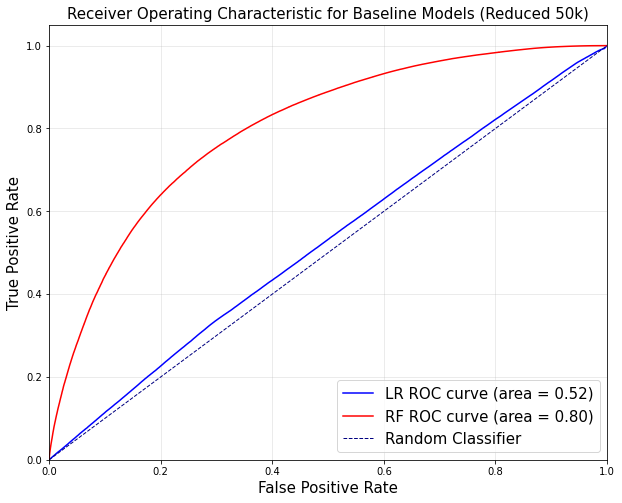

In [ ]:
tpr_lr, fpr_lr, auc_lr = test_scores_50klr["roc"].values()
tpr_rf, fpr_rf, auc_rf = test_scores_50krf["roc"].values()

fig = plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color="blue", 
         label=f"LR ROC curve (area = {auc_lr:.2f})")
plt.plot(fpr_rf, tpr_rf, color="red", 
         label=f"RF ROC curve (area = {auc_rf:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random Classifier")
# plt.plot([0, 0, 1], [0, 1, 1], color="darkorange", lw=1, linestyle="-", label="Perfect Classifier")

plt.legend(fontsize=15)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Receiver Operating Characteristic for Baseline Models (Reduced 50k)", fontsize=15)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.savefig("plots/baseline_roc_curves.png")
plt.show()

## GNN Results

In [ ]:
def get_GNN_score(path):
    test_data_gnn, model_gnn = load_experiment(path)
    test_scores_gnn = model_gnn.test(full_test_dataset_pyg[0])
    return test_scores_gnn

In [ ]:
file_path_gnn_r10kA = "../results/reduced_10k/gnn/04132022_113016"
file_path_gnn_r10kB = "../results/reduced_10k/gnn/04132022_113205"
file_path_gnn_r10kC = "../results/reduced_10k/gnn/04132022_113452"

socres_gnn_r10kA = get_GNN_score(file_path_gnn_r10kA)
socres_gnn_r10kB = get_GNN_score(file_path_gnn_r10kB)
socres_gnn_r10kC = get_GNN_score(file_path_gnn_r10kC)


file_path_gnn_r50kA = "../results/reduced_50k/gnn/04132022_113935"
file_path_gnn_r50kB = "../results/reduced_50k/gnn/04132022_114525"
file_path_gnn_r50kC = "../results/reduced_50k/gnn/04132022_115701"

socres_gnn_r50kA = get_GNN_score(file_path_gnn_r50kA)
socres_gnn_r50kB = get_GNN_score(file_path_gnn_r50kB)
socres_gnn_r50kC = get_GNN_score(file_path_gnn_r50kC)

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [ ]:
print(55*"-")
print("Training Set | Model    | Precision | Recall | F1-score")
print(55*"-")
print(f"Reduced 10k  | GNN A    | {socres_gnn_r10kA['precision']:.2f}\t    | {socres_gnn_r10kA['recall']:.2f}   | {socres_gnn_r10kA['f1-score']:.2f}")
print(f"             | GNN B    | {socres_gnn_r10kB['precision']:.2f}\t    | {socres_gnn_r10kB['recall']:.2f}   | {socres_gnn_r10kB['f1-score']:.2f}")
print(f"             | GNN C    | {socres_gnn_r10kC['precision']:.2f}\t    | {socres_gnn_r10kC['recall']:.2f}   | {socres_gnn_r10kC['f1-score']:.2f}")
print(55*"-")
print(f"Reduced 50k  | GNN A    | {socres_gnn_r50kA['precision']:.2f}\t    | {socres_gnn_r50kA['recall']:.2f}   | {socres_gnn_r50kA['f1-score']:.2f}")
print(f"             | GNN B    | {socres_gnn_r50kB['precision']:.2f}\t    | {socres_gnn_r50kB['recall']:.2f}   | {socres_gnn_r50kB['f1-score']:.2f}")
print(f"             | GNN C    | {socres_gnn_r50kC['precision']:.2f}\t    | {socres_gnn_r50kC['recall']:.2f}   | {socres_gnn_r50kC['f1-score']:.2f}")
print(55*"-")


-------------------------------------------------------
Training Set | Model    | Precision | Recall | F1-score
-------------------------------------------------------
Reduced 10k  | GNN A    | 0.97	    | 0.74   | 0.84
             | GNN B    | 0.99	    | 0.79   | 0.88
             | GNN C    | 0.99	    | 0.70   | 0.82
-------------------------------------------------------
Reduced 50k  | GNN A    | 0.97	    | 0.76   | 0.85
             | GNN B    | 0.99	    | 0.79   | 0.88
             | GNN C    | 0.96	    | 0.78   | 0.86
-------------------------------------------------------


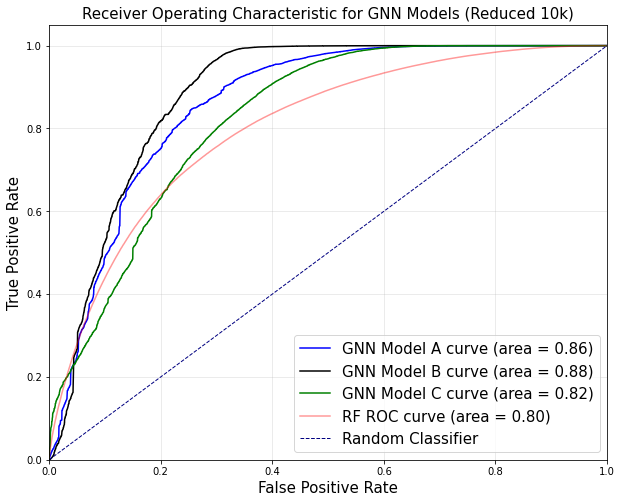

In [ ]:
tpr_A, fpr_A, auc_A = socres_gnn_r10kA["roc"].values()
tpr_B, fpr_B, auc_B = socres_gnn_r10kB["roc"].values()
tpr_C, fpr_C, auc_C = socres_gnn_r10kC["roc"].values()
tpr_rf, fpr_rf, auc_rf = test_scores_10krf["roc"].values()

fig = plt.figure(figsize=(10, 8))
plt.plot(fpr_A, tpr_A, color="blue", 
         label=f"GNN Model A curve (area = {auc_A:.2f})")
plt.plot(fpr_B, tpr_B, color="black", 
         label=f"GNN Model B curve (area = {auc_B:.2f})")
plt.plot(fpr_C, tpr_C, color="green", 
         label=f"GNN Model C curve (area = {auc_C:.2f})")
plt.plot(fpr_rf, tpr_rf, color="red", 
         label=f"RF ROC curve (area = {auc_rf:.2f})", alpha =0.4)
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random Classifier")
# plt.plot([0, 0, 1], [0, 1, 1], color="darkorange", lw=1, linestyle="-", label="Perfect Classifier")

plt.legend(fontsize=15)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Receiver Operating Characteristic for GNN Models (Reduced 10k)", fontsize=15)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.savefig("plots/GNN_roc_curves_10k.png")
plt.show()

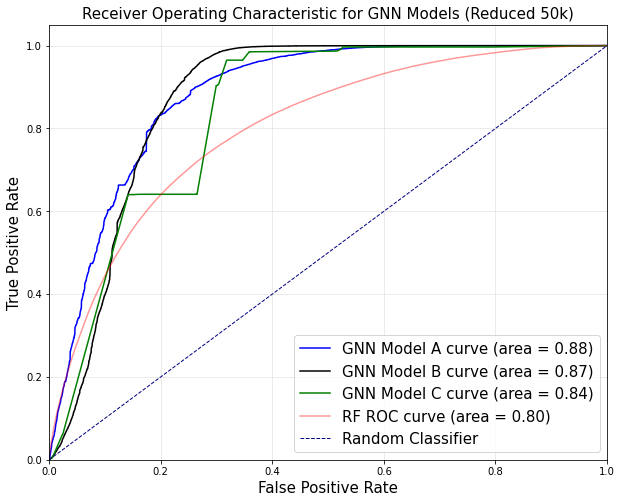

In [ ]:
tpr_A, fpr_A, auc_A = socres_gnn_r50kA["roc"].values()
tpr_B, fpr_B, auc_B = socres_gnn_r50kB["roc"].values()
tpr_C, fpr_C, auc_C = socres_gnn_r50kC["roc"].values()
tpr_rf, fpr_rf, auc_rf = test_scores_50krf["roc"].values()

fig = plt.figure(figsize=(10, 8))
plt.plot(fpr_A, tpr_A, color="blue", 
         label=f"GNN Model A curve (area = {auc_A:.2f})")
plt.plot(fpr_B, tpr_B, color="black", 
         label=f"GNN Model B curve (area = {auc_B:.2f})")
plt.plot(fpr_C, tpr_C, color="green", 
         label=f"GNN Model C curve (area = {auc_C:.2f})")
plt.plot(fpr_rf, tpr_rf, color="red", 
         label=f"RF ROC curve (area = {auc_rf:.2f})", alpha =0.4)
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random Classifier")
# plt.plot([0, 0, 1], [0, 1, 1], color="darkorange", lw=1, linestyle="-", label="Perfect Classifier")

plt.legend(fontsize=15)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Receiver Operating Characteristic for GNN Models (Reduced 50k)", fontsize=15)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.savefig("plots/GNN_roc_curves_50k.png")
plt.show()

## Different Country Markets

In [ ]:
def get_GNN_and_testdata(path):
    data_gnn, test_data_gnn, model_gnn = load_experiment(path)
    return model_gnn, test_data_gnn

file_path_lr_Oz = "../results/Oz_reduced_50k/baseline_lr/04132022_213915"
file_path_lr_Aus = "../results/Aus_reduced_50k/baseline_lr/04132022_212945"
file_path_lr_Den = "../results/Den_reduced_50k/baseline_lr/04132022_213400"
file_path_lr_Fr = "../results/Fr_reduced_50k/baseline_lr/04132022_213545"
file_path_lr_Ger = "../results/Ger_reduced_50k/baseline_lr/04132022_213729"
# file_path_gnn_Ned = "../results/Ned_reduced_50k/gnn/04132022_113452"
# file_path_gnn_Swe = "../results/Swe_reduced_50k/gnn/04132022_113016"
# file_path_gnn_UK = "../results/UK_reduced_50k/gnn/04132022_113205"
# file_path_gnn_US = "../results/US_reduced_50k/gnn/04132022_113452"
# file_path_gnn_Oth = "../results/Oth_reduced_50k/gnn/04132022_113452"
file_path_lr_All = "../results/reduced_50k/baseline_lr/04132022_215352"

file_path_rf_Oz = "../results/Oz_reduced_50k/baseline_rf/04132022_213956"
file_path_rf_Aus = "../results/Aus_reduced_50k/baseline_rf/04132022_213305"
file_path_rf_Den = "../results/Den_reduced_50k/baseline_rf/04132022_213453"
file_path_rf_Fr = "../results/Fr_reduced_50k/baseline_rf/04132022_213640"
file_path_rf_Ger = "../results/Ger_reduced_50k/baseline_rf/04132022_213820"
# file_path_gnn_Ned = "../results/Ned_reduced_50k/gnn/04132022_113452"
# file_path_gnn_Swe = "../results/Swe_reduced_50k/gnn/04132022_113016"
# file_path_gnn_UK = "../results/UK_reduced_50k/gnn/04132022_113205"
# file_path_gnn_US = "../results/US_reduced_50k/gnn/04132022_113452"
# file_path_gnn_Oth = "../results/Oth_reduced_50k/gnn/04132022_113452"
file_path_rf_All = "../results/reduced_50k/baseline_rf/04132022_215233"

lr_Oz, test_data_lrOz = get_GNN_and_testdata(file_path_lr_Oz)
lr_Aus, test_data_lrAus = get_GNN_and_testdata(file_path_lr_Aus)
lr_Den, test_data_lrDen = get_GNN_and_testdata(file_path_lr_Den)
lr_Fr, test_data_lrFr = get_GNN_and_testdata(file_path_lr_Fr)
lr_Ger, test_data_lrGer = get_GNN_and_testdata(file_path_lr_Ger)
# socres_gnn_Ned = get_GNN_score(file_path_gnn_Ned)
# socres_gnn_Swe = get_GNN_score(file_path_gnn_Swe)
# socres_gnn_UK = get_GNN_score(file_path_gnn_UK)
# socres_gnn_US = get_GNN_score(file_path_gnn_US)
# socres_gnn_Oth = get_GNN_score(file_path_gnn_Oth)
lr_All, test_data_lrAll = get_GNN_and_testdata(file_path_lr_All)

rf_Oz, test_data_rfOz = get_GNN_and_testdata(file_path_rf_Oz)
rf_Aus, test_data_rfAus = get_GNN_and_testdata(file_path_rf_Aus)
rf_Den, test_data_rfDen = get_GNN_and_testdata(file_path_rf_Den)
rf_Fr, test_data_rfFr = get_GNN_and_testdata(file_path_rf_Fr)
rf_Ger, test_data_rfGer = get_GNN_and_testdata(file_path_rf_Ger)
# socres_gnn_Ned = get_GNN_score(file_path_gnn_Ned)
# socres_gnn_Swe = get_GNN_score(file_path_gnn_Swe)
# socres_gnn_UK = get_GNN_score(file_path_gnn_UK)
# socres_gnn_US = get_GNN_score(file_path_gnn_US)
# socres_gnn_Oth = get_GNN_score(file_path_gnn_Oth)
rf_All, test_data_rfAll = get_GNN_and_testdata(file_path_rf_All)

In [ ]:
lrscores_Oz_Oz = lr_Oz.test((test_data_lrOz.data.X, test_data_lrOz.data.y))
lrscores_Aus_Aus = lr_Aus.test((test_data_lrAus.data.X, test_data_lrAus.data.y))
lrscores_Den_Den = lr_Den.test((test_data_lrDen.data.X, test_data_lrDen.data.y))
lrscores_Fr_Fr = lr_Fr.test((test_data_lrFr.data.X, test_data_lrFr.data.y))
lrscores_Ger_Ger = lr_Ger.test((test_data_lrGer.data.X, test_data_lrGer.data.y))
# scores_Ned_Ned = gnn_Ned.test(test_data_Ned[0])
# scores_Swe_Swe = gnn_Swe.test(test_data_Swe[0])
# scores_UK_UK = gnn_UK.test(test_data_UK[0])
# scores_US_US = gnn_US.test(test_data_US[0])
# scores_Oth_Oth = gnn_Oth.test(test_data_Oth[0])

lrscores_all_Oz = lr_All.test((test_data_lrOz.data.X, test_data_lrOz.data.y))
lrscores_all_Aus = lr_All.test((test_data_lrAus.data.X, test_data_lrAus.data.y))
lrscores_all_Den = lr_All.test((test_data_lrDen.data.X, test_data_lrDen.data.y))
lrscores_all_Fr = lr_All.test((test_data_lrFr.data.X, test_data_lrFr.data.y))
lrscores_all_Ger = lr_All.test((test_data_lrGer.data.X, test_data_lrGer.data.y))

rfscores_Oz_Oz = rf_Oz.test((test_data_lrOz.data.X, test_data_lrOz.data.y))
rfscores_Aus_Aus = rf_Aus.test((test_data_lrAus.data.X, test_data_lrAus.data.y))
rfscores_Den_Den = rf_Den.test((test_data_lrDen.data.X, test_data_lrDen.data.y))
rfscores_Fr_Fr = rf_Fr.test((test_data_lrFr.data.X, test_data_lrFr.data.y))
rfscores_Ger_Ger = rf_Ger.test((test_data_lrGer.data.X, test_data_lrGer.data.y))
# scores_Ned_Ned = gnn_Ned.test(test_data_Ned[0])
# scores_Swe_Swe = gnn_Swe.test(test_data_Swe[0])
# scores_UK_UK = gnn_UK.test(test_data_UK[0])
# scores_US_US = gnn_US.test(test_data_US[0])
# scores_Oth_Oth = gnn_Oth.test(test_data_Oth[0])

rfscores_all_Oz = rf_All.test((test_data_lrOz.data.X, test_data_lrOz.data.y))
rfscores_all_Aus = rf_All.test((test_data_lrAus.data.X, test_data_lrAus.data.y))
rfscores_all_Den = rf_All.test((test_data_lrDen.data.X, test_data_lrDen.data.y))
rfscores_all_Fr = rf_All.test((test_data_lrFr.data.X, test_data_lrFr.data.y))
rfscores_all_Ger = rf_All.test((test_data_lrGer.data.X, test_data_lrGer.data.y))

In [ ]:
file_path_gnn_Oz = "../results/Oz_reduced_50k/gnn/04132022_174936"
file_path_gnn_Aus = "../results/Aus_reduced_50k/gnn/04132022_170128"
file_path_gnn_Den = "../results/Den_reduced_50k/gnn/04132022_170339"
file_path_gnn_Fr = "../results/Fr_reduced_50k/gnn/04132022_170517"
file_path_gnn_Ger = "../results/Ger_reduced_50k/gnn/04132022_175101"
# file_path_gnn_Ned = "../results/Ned_reduced_50k/gnn/04132022_113452"
# file_path_gnn_Swe = "../results/Swe_reduced_50k/gnn/04132022_113016"
# file_path_gnn_UK = "../results/UK_reduced_50k/gnn/04132022_113205"
# file_path_gnn_US = "../results/US_reduced_50k/gnn/04132022_113452"
# file_path_gnn_Oth = "../results/Oth_reduced_50k/gnn/04132022_113452"
file_path_gnn_All = "../results/reduced_50k/gnn/04132022_180640"

gnn_Oz, test_data_Oz = get_GNN_and_testdata(file_path_gnn_Oz)
gnn_Aus, test_data_Aus = get_GNN_and_testdata(file_path_gnn_Aus)
gnn_Den, test_data_Den = get_GNN_and_testdata(file_path_gnn_Den)
gnn_Fr, test_data_Fr = get_GNN_and_testdata(file_path_gnn_Fr)
gnn_Ger, test_data_Ger = get_GNN_and_testdata(file_path_gnn_Ger)
# socres_gnn_Ned = get_GNN_score(file_path_gnn_Ned)
# socres_gnn_Swe = get_GNN_score(file_path_gnn_Swe)
# socres_gnn_UK = get_GNN_score(file_path_gnn_UK)
# socres_gnn_US = get_GNN_score(file_path_gnn_US)
# socres_gnn_Oth = get_GNN_score(file_path_gnn_Oth)
gnn_All, test_data_All = get_GNN_and_testdata(file_path_gnn_All)

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [ ]:
scores_Oz_Oz = gnn_Oz.test(test_data_Oz.data[0])
scores_Aus_Aus = gnn_Aus.test(test_data_Aus.data[0])
scores_Den_Den = gnn_Den.test(test_data_Den.data[0])
scores_Fr_Fr = gnn_Fr.test(test_data_Fr.data[0])
scores_Ger_Ger = gnn_Ger.test(test_data_Ger.data[0])
# scores_Ned_Ned = gnn_Ned.test(test_data_Ned[0])
# scores_Swe_Swe = gnn_Swe.test(test_data_Swe[0])
# scores_UK_UK = gnn_UK.test(test_data_UK[0])
# scores_US_US = gnn_US.test(test_data_US[0])
# scores_Oth_Oth = gnn_Oth.test(test_data_Oth[0])

scores_all_Oz = gnn_All.test(test_data_Oz.data[0])
scores_all_Aus = gnn_All.test(test_data_Aus.data[0])
scores_all_Den = gnn_All.test(test_data_Den.data[0])
scores_all_Fr = gnn_All.test(test_data_Fr.data[0])
scores_all_Ger = gnn_All.test(test_data_Ger.data[0])

scores_Oz_all = gnn_Oz.test(test_data_All.data[0])
scores_Aus_all = gnn_Aus.test(test_data_All.data[0])
scores_Den_all = gnn_Den.test(test_data_All.data[0])
scores_Fr_all = gnn_Fr.test(test_data_All.data[0])
scores_Ger_all = gnn_Ger.test(test_data_All.data[0])
scores_all_all = gnn_All.test(test_data_All.data[0])

In [ ]:
print(65*"-")
print("Model         | Australia  | Austria | Denmark | France | Germany")
print(65*"-")
print(f"Log Reg       | {lrscores_Oz_Oz['f1-score']:.3f}      | {lrscores_Aus_Aus['f1-score']:.3f}   | {lrscores_Den_Den['f1-score']:.3f}   | {lrscores_Fr_Fr['f1-score']:.3f}  | {lrscores_Ger_Ger['f1-score']:.3f}")
print(f"Rnd Fst       | {rfscores_Oz_Oz['f1-score']:.3f}      | {rfscores_Aus_Aus['f1-score']:.3f}   | {rfscores_Den_Den['f1-score']:.3f}   | {rfscores_Fr_Fr['f1-score']:.3f}  | {rfscores_Ger_Ger['f1-score']:.3f}")
print(f"GNN B         | {scores_Oz_Oz['f1-score']:.3f}      | {scores_Aus_Aus['f1-score']:.3f}   | {scores_Den_Den['f1-score']:.3f}   | {scores_Fr_Fr['f1-score']:.3f}  | {scores_Ger_Ger['f1-score']:.3f}")
print(65*"-")
print(f"Log Reg (All) | {lrscores_all_Oz['f1-score']:.3f}      | {lrscores_all_Aus['f1-score']:.3f}   | {lrscores_all_Den['f1-score']:.3f}   | {lrscores_all_Fr['f1-score']:.3f}  | {lrscores_all_Ger['f1-score']:.3f}")
print(f"Rnd Fst (All) | {rfscores_all_Oz['f1-score']:.3f}      | {rfscores_all_Aus['f1-score']:.3f}   | {rfscores_all_Den['f1-score']:.3f}   | {rfscores_all_Fr['f1-score']:.3f}  | {rfscores_all_Ger['f1-score']:.3f}")
print(f"GNN B (All)   | {scores_all_Oz['f1-score']:.3f}      | {scores_all_Aus['f1-score']:.3f}   | {scores_all_Den['f1-score']:.3f}   | {scores_all_Fr['f1-score']:.3f}  | {scores_all_Ger['f1-score']:.3f}")
print(65*"-")


-----------------------------------------------------------------
Model         | Australia  | Austria | Denmark | France | Germany
-----------------------------------------------------------------
Log Reg       | 0.124      | 0.745   | 0.202   | 0.003  | 0.782
Rnd Fst       | 0.635      | 0.788   | 0.645   | 0.519  | 0.811
GNN B         | 0.920      | 0.987   | 0.991   | 0.966  | 0.925
-----------------------------------------------------------------
Log Reg (All) | 0.602      | 0.745   | 0.607   | 0.545  | 0.780
Rnd Fst (All) | 0.653      | 0.782   | 0.665   | 0.597  | 0.816
GNN B (All)   | 0.921      | 0.951   | 0.920   | 0.909  | 0.917
-----------------------------------------------------------------


In [ ]:
print(45*"-")
print("GNN Trained on   | F1-score on all countries  ")
print(45*"-")
print(f"Australia        | {scores_Oz_all['f1-score']:.3f}")
print(f"Austria          | {scores_Aus_all['f1-score']:.3f}  ")
print(f"Denmark          | {scores_Den_all['f1-score']:.3f}  ")
print(f"France           | {scores_Fr_all['f1-score']:.3f}   ")
print(f"Germany          | {scores_Ger_all['f1-score']:.3f}   ")
print(45*"-")
print(f"All              | {scores_all_all['f1-score']:.3f} ")
print(45*"-")

---------------------------------------------
GNN Trained on   | F1-score on all countries  
---------------------------------------------
Australia        | 0.848
Austria          | 0.868  
Denmark          | 0.876  
France           | 0.863   
Germany          | 0.866   
---------------------------------------------
All              | 0.887 
---------------------------------------------


## German's who bought ASOS Design

In [ ]:
file_path = "../results/full/gnn/04142022_095109"

gnn_Ger_ASOS, test_data_GER_ASOS = get_GNN_and_testdata(file_path)

Processing...
Done!
Processing...
Done!


In [ ]:
test_data_GER_ASOS.data[0]

HeteroData(
  customer={
    x=[122858, 30],
    num_nodes=122858,
    node_index=[122858]
  },
  product={
    x=[111773, 41],
    num_nodes=111773,
    node_index=[111773]
  },
  (customer, purchases, product)={
    edge_index=[2, 14739],
    edge_label=[14739]
  },
  (product, purchased_by, customer)={ edge_index=[2, 14739] },
  (customer, returns, product)={ edge_index=[2, 10317] },
  (product, returned_by, customer)={ edge_index=[2, 10317] }
)

In [ ]:
test_data_GER_ASOS.data.data["customer"]["x"][:,-10:].sum(axis=0)

tensor([     0.,      0.,      0.,      0., 122858.,      0.,      0.,      0.,
             0.,      0.])

In [ ]:
test_data_GER_ASOS.data.data["product"]["x"][:,-21:-11].sum(axis=0)

tensor([     0., 111773.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.])

In [ ]:
scores = gnn_Ger_ASOS.test(test_data_GER_ASOS.data[0])

In [ ]:
scores["f1-score"]

0.8235153256704981

<AxesSubplot:ylabel='Frequency'>

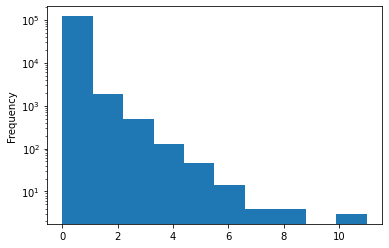

In [ ]:
import torch_geometric.utils as U
import pandas as pd

node_degree = U.degree(test_data_GER_ASOS.data.data['product', 'purchased_by', 'customer'].edge_index[1])
pd.Series(node_degree.cpu()).plot.hist(bins=10, range=(0,11), log= True)

In [ ]:
gnn_Ger.test(test_data_GER_ASOS.data[0])

NameError: name 'gnn_Ger' is not defined